In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, regularizers, Sequential
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt

In [88]:
df = pd.read_csv('data/SuperMarket Analysis.csv')
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,1:08:00 PM,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00 AM,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,1:23:00 PM,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,8:33:00 PM,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00 AM,Ewallet,604.17,4.761905,30.2085,5.3


In [89]:
df['UnitPriceLog'] = np.log1p(df['Unit price'])

df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

df.drop(['Date', 'Time', 'Invoice ID'], axis=1, inplace=True)

C:\Users\mateuszlamla\AppData\Local\Temp\ipykernel_9464\1321478894.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour


In [90]:
# df_encoded = pd.get_dummies(df, drop_first=True)
# df_encoded.head()

columns_to_encode = ['Branch', 'City', 'Customer type','Gender', 'Product line', 'Payment']

for col in columns_to_encode:
    unique_vals = df[col].unique()
    mapping = {val: i+1 for i, val in enumerate(unique_vals)}
    df[col + '_id'] = df[col].map(mapping)
df.drop(columns_to_encode, axis=1, inplace=True)



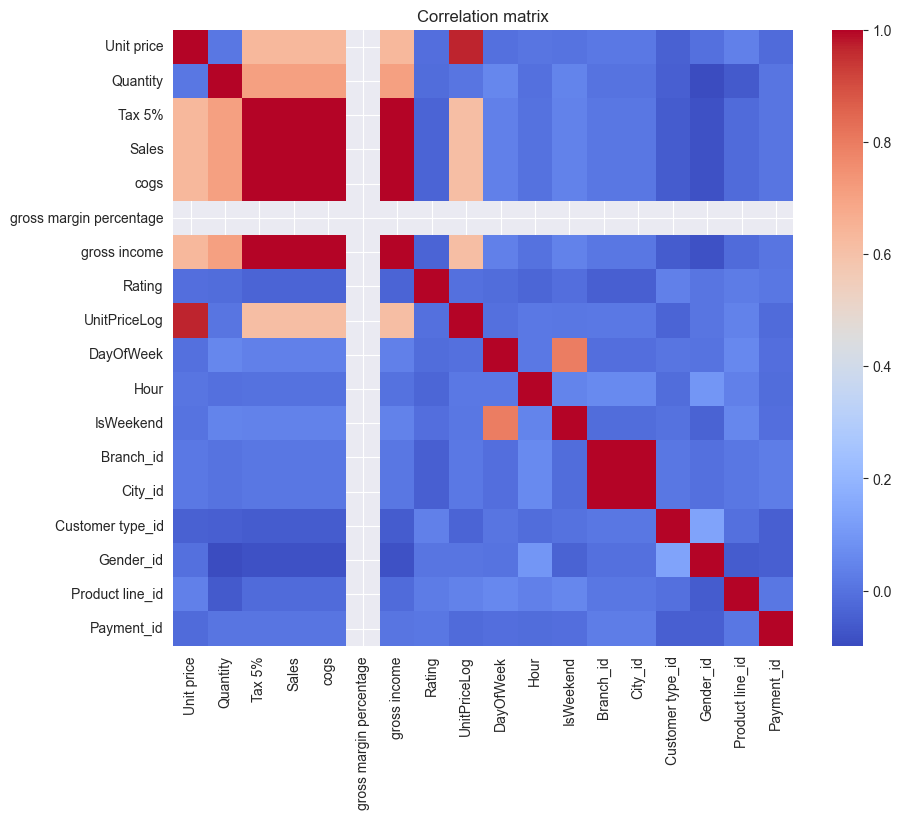

In [91]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation matrix")
plt.show()

In [92]:
X = df.drop('UnitPriceLog', axis=1)
Y = df['UnitPriceLog']

In [93]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [94]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

Y_train_scaled = scaler_Y.fit_transform(Y_train.values.reshape(-1,1))
Y_test_scaled  = scaler_Y.transform(Y_test.values.reshape(-1,1))

In [95]:
#ewaluacja modelu
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, max_error, explained_variance_score

def evaluate_model(model, X_train, X_test, Y_train, Y_test, scaler_Y=None):
    pred_train_scaled = model.predict(X_train).reshape(-1, 1)
    pred_test_scaled = model.predict(X_test).reshape(-1, 1)

    y_train = scaler_Y.inverse_transform(Y_train_scaled).reshape(-1)
    y_test = scaler_Y.inverse_transform(Y_test_scaled).reshape(-1)

    pred_train = scaler_Y.inverse_transform(pred_train_scaled).reshape(-1)
    pred_test = scaler_Y.inverse_transform(pred_test_scaled).reshape(-1)

    def mape(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true))

    def smape(y_true, y_pred):
        return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

    metrics = {
        "MAE" : mean_absolute_error(y_test, pred_test),
        "MSE" : mean_squared_error(y_test, pred_test),
        "RMSE" : np.sqrt(mean_squared_error(y_test, pred_test)),
        "R2" : r2_score(y_test, pred_test),
        "MedAE" : median_absolute_error(y_test, pred_test),
        "MaxError" : max_error(y_test, pred_test),
        "MAPE" : mape(y_test, pred_test),
        "SMAPE" : smape(y_test, pred_test),
        "ExplainedVar" : explained_variance_score(y_test, pred_test)
    }
    return metrics, pred_test

def plot_actual_vs_predict(y_test, y_pred):
    plt.figure(figsize=(8,5))
    plt.scatter(range(len(Y_actual)), y_test, label="Actual", alpha=0.6)
    plt.scatter(range(len(Y_pred)), y_pred, label="Prediction", alpha=0.6)
    plt.xlabel("Samples")
    plt.ylabel("Unit Price")
    plt.title("Prediction vs Actual")
    plt.legend()
    plt.show()

def plot_residuals(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(7,6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color="red")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.grid(True)
    plt.show()

def plot_learning_curve(history):
    plt.figure(figsize=(10,5))
    plt.title("Learning Curve")
    plt.plot(history.history['loss'], label="train loss")
    plt.plot(history.history['val_loss'], label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_error(y_test, y_pred):
    errors = y_test - y_pred
    plt.figure(figsize=(8,5))
    plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel("Prediction Error")
    plt.ylabel("Count")
    plt.title("Histogram of Prediction Errors")
    plt.show()

In [96]:
from keras_tuner.src.backend import keras


def build_model(input_dim):
        # model = Sequential()
        # # Warstwa ukryta 1
        # model.add(layers.Dense(96, activation='relu',
        #                        input_shape=(input_dim,),
        #                        kernel_regularizer=regularizers.l2(0.001)))
        # model.add(layers.BatchNormalization())
        # model.add(layers.Dropout(0.3))
        # 
        # # Warstwa ukryta 2
        # model.add(layers.Dense(96, activation='relu',
        #                        kernel_regularizer=regularizers.l2(0.001)))
        # model.add(layers.BatchNormalization())
        # model.add(layers.Dropout(0.3))
        # 
        # # Wyjście
        # model.add(layers.Dense(1, activation='linear'))
        # 
        # model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        # return model
        model = Sequential()

        # Warstwa 0
        model.add(layers.Dense(
            128, 
            activation='relu',
            input_shape=(input_dim,),
            kernel_regularizer=regularizers.l2(0.001)
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.1))

        # Warstwa 1
        model.add(layers.Dense(
            96, 
            activation='relu',
            kernel_regularizer=regularizers.l2(0.001)
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.01))

        # Wyjście
        model.add(layers.Dense(1, activation='linear'))

        # learning rate z Bayes results
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.01),
            loss='mse',
            metrics=['mae']
        )

        return model

# EarlyStopping
es = EarlyStopping(patience=15, restore_best_weights=True)

input_dim = X_train_scaled.shape[1]
model = build_model(input_dim)
# Trening
history = model.fit(
    X_train_scaled, Y_train_scaled,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es]
)

Epoch 1/200


C:\Users\mateuszlamla\PyCharmMiscProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.3113 - mae: 0.7477 - val_loss: 0.2846 - val_mae: 0.2688
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2590 - mae: 0.2401 - val_loss: 0.2201 - val_mae: 0.1847
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2056 - mae: 0.1597 - val_loss: 0.2065 - val_mae: 0.1739
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1836 - mae: 0.1296 - val_loss: 0.1985 - val_mae: 0.1811
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1685 - mae: 0.1122 - val_loss: 0.1852 - val_mae: 0.1698
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1559 - mae: 0.0995 - val_loss: 0.1768 - val_mae: 0.1717
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1488 - mae: 0.1040 - val_loss: 0.1702 - val_mae: 0.1765
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1385 - mae: 0.0923 - val_loss: 0.1602 - val_mae: 0.1690
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1312 - mae: 0.

In [97]:
Y_pred_scaled = model.predict(X_test_scaled).flatten()
Y_pred = np.expm1(scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1,1))).flatten()
Y_actual = np.expm1(scaler_Y.inverse_transform(Y_test_scaled.reshape(-1,1))).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [98]:
wynikowa = pd.DataFrame(columns=['title','MAE','MSE','RMSE','R2'])

In [99]:
title = 'Bayesian parameters'
mae = mean_absolute_error(Y_actual, Y_pred)
mse = mean_squared_error(Y_actual, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_actual, Y_pred)
wynikowa.loc[len(wynikowa)] = [title, mae, mse, rmse, r2]
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")

MAE: 2.229
MSE: 6.641
RMSE: 2.577
R2: 0.991


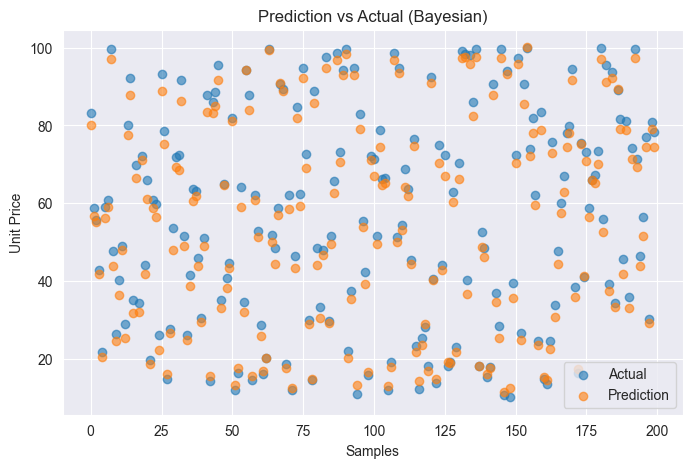

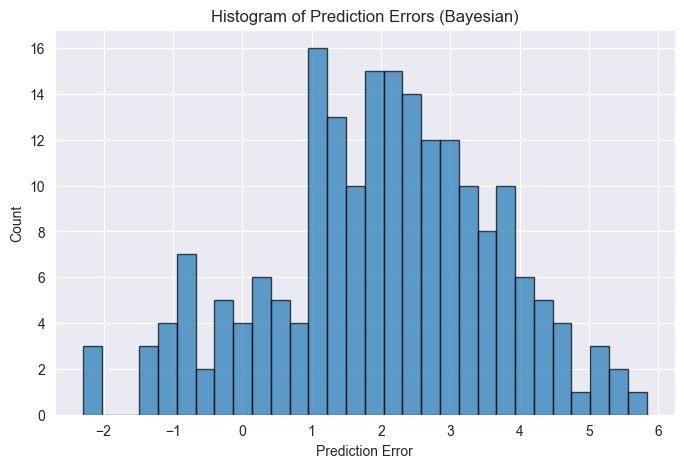

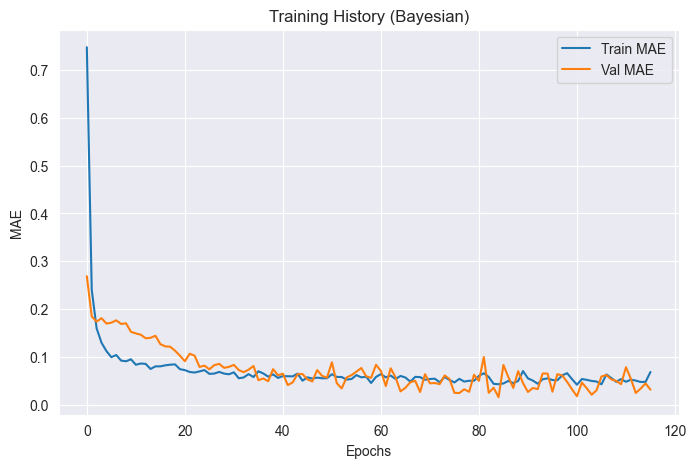

In [100]:
plt.figure(figsize=(8,5))
plt.scatter(range(len(Y_actual)), Y_actual, label="Actual", alpha=0.6)
plt.scatter(range(len(Y_pred)), Y_pred, label="Prediction", alpha=0.6)
plt.xlabel("Samples")
plt.ylabel("Unit Price")
plt.title("Prediction vs Actual (Bayesian)")
plt.legend()
plt.show()

errors = Y_actual - Y_pred
plt.figure(figsize=(8,5))
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("Histogram of Prediction Errors (Bayesian)")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training History (Bayesian)")
plt.legend()
plt.show()

In [101]:
def build_simple_model(input_dim):
    model = Sequential()
    model.add(layers.Dense(32, activation='relu', input_shape=(input_dim,)))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

simple_model = build_simple_model(input_dim)
history_simple = simple_model.fit(
    X_train_scaled, Y_train_scaled,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
)

Epoch 1/200


C:\Users\mateuszlamla\PyCharmMiscProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5605 - mae: 0.6191 - val_loss: 0.2717 - val_mae: 0.4367
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2082 - mae: 0.3775 - val_loss: 0.1905 - val_mae: 0.3430
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1399 - mae: 0.3025 - val_loss: 0.1222 - val_mae: 0.2804
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0953 - mae: 0.2507 - val_loss: 0.0862 - val_mae: 0.2337
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0691 - mae: 0.2095 - val_loss: 0.0647 - val_mae: 0.2039
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0524 - mae: 0.1820 - val_loss: 0.0512 - val_mae: 0.1826
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0422 - mae: 0.1646 - val_loss: 0.0414 - val_mae: 0.1654
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0348 - mae: 0.1493 - val_loss: 0.0343 - val_mae: 0.1494
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0290 - mae: 0.1

In [102]:
Y_pred_scaled = simple_model.predict(X_test_scaled).flatten()
Y_pred = np.expm1(scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1,1))).flatten()
Y_actual = np.expm1(scaler_Y.inverse_transform(Y_test_scaled.reshape(-1,1))).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


MAE: 2.932
MSE: 15.705
RMSE: 3.963
R2: 0.979


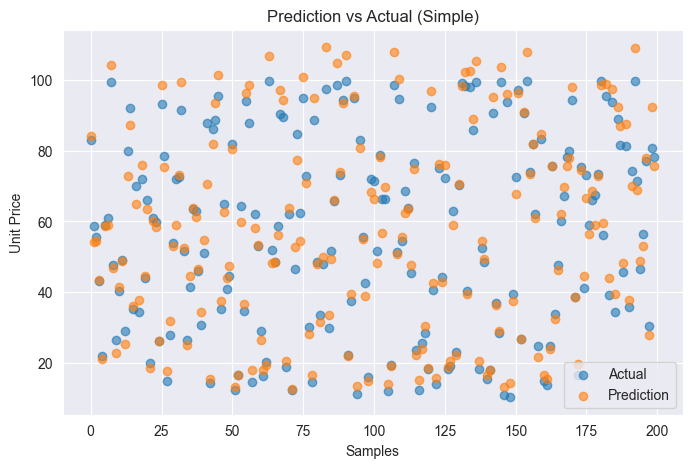

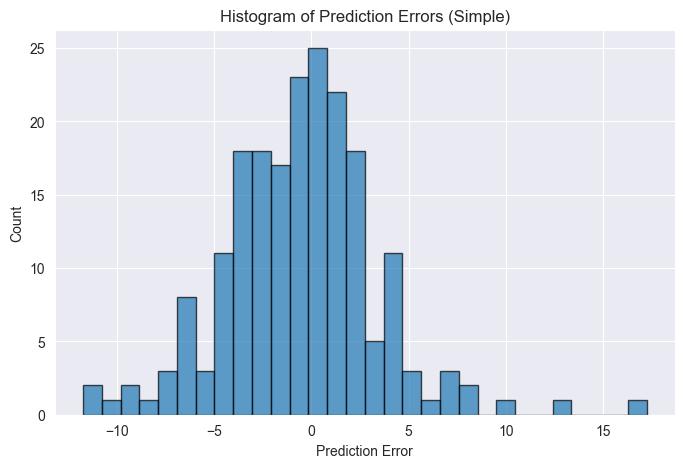

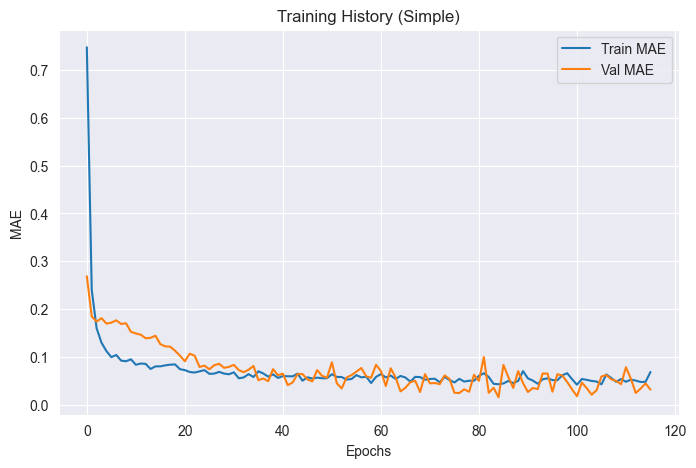

In [103]:
title='Simple'
mae = mean_absolute_error(Y_actual, Y_pred)
mse = mean_squared_error(Y_actual, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_actual, Y_pred)
wynikowa.loc[len(wynikowa)]=[title, mae, mse, rmse, r2]
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")
plt.figure(figsize=(8,5))
plt.scatter(range(len(Y_actual)), Y_actual, label="Actual", alpha=0.6)
plt.scatter(range(len(Y_pred)), Y_pred, label="Prediction", alpha=0.6)
plt.xlabel("Samples")
plt.ylabel("Unit Price")
plt.title("Prediction vs Actual (Simple)")
plt.legend()
plt.show()

errors = Y_actual - Y_pred
plt.figure(figsize=(8,5))
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("Histogram of Prediction Errors (Simple)")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training History (Simple)")
plt.legend()
plt.show()

In [104]:
def build_medium_model(input_dim):
    model = Sequential()

    model.add(layers.Dense(128, activation='relu', input_shape=(input_dim,)))

    model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

medium_model = build_medium_model(input_dim)
history_medium = medium_model.fit(
    X_train_scaled, Y_train_scaled,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    #callbacks=[es]
)

Epoch 1/200


C:\Users\mateuszlamla\PyCharmMiscProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2331 - mae: 0.3806 - val_loss: 0.1101 - val_mae: 0.2686
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0528 - mae: 0.1840 - val_loss: 0.0376 - val_mae: 0.1566
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0291 - mae: 0.1363 - val_loss: 0.0211 - val_mae: 0.1160
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0155 - mae: 0.1000 - val_loss: 0.0109 - val_mae: 0.0858
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - mae: 0.0759 - val_loss: 0.0082 - val_mae: 0.0761
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - mae: 0.0619 - val_loss: 0.0055 - val_mae: 0.0595
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - mae: 0.0532 - val_loss: 0.0042 - val_mae: 0.0522
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - mae: 0.0473 - val_loss: 0.0035 - val_mae: 0.0460
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - mae: 0.

In [105]:
Y_pred_scaled = medium_model.predict(X_test_scaled).flatten()
Y_pred = np.expm1(scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1,1))).flatten()
Y_actual = np.expm1(scaler_Y.inverse_transform(Y_test_scaled.reshape(-1,1))).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


MAE: 1.996
MSE: 6.676
RMSE: 2.584
R2: 0.991


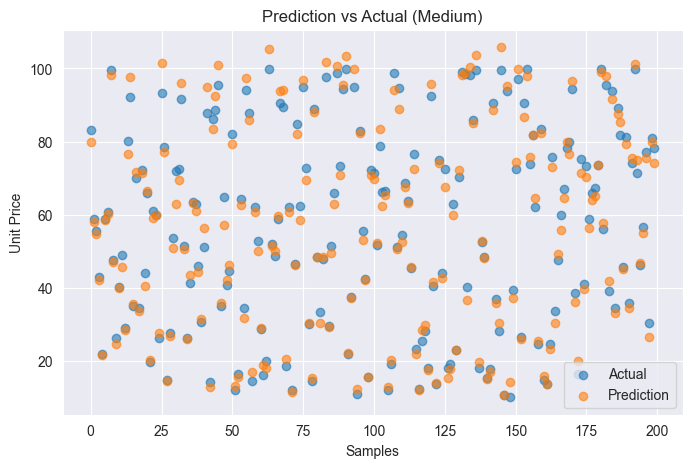

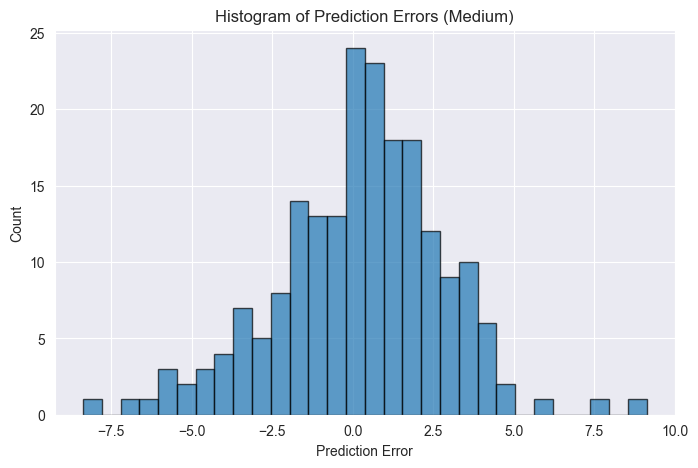

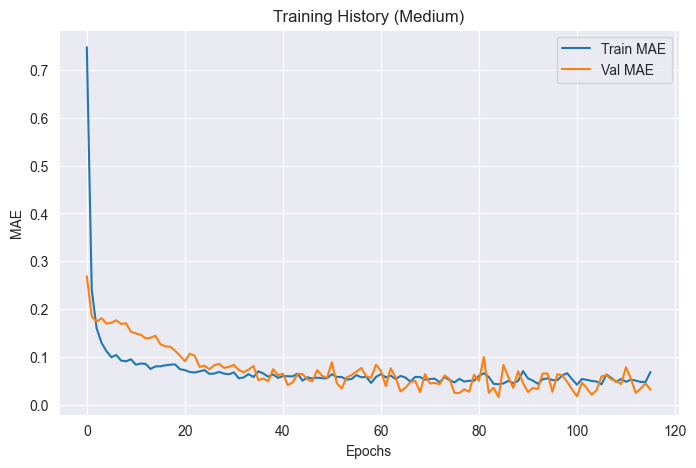

In [106]:
title='Medium'
mae = mean_absolute_error(Y_actual, Y_pred)
mse = mean_squared_error(Y_actual, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_actual, Y_pred)
wynikowa.loc[len(wynikowa)]=[title,mae,mse,rmse,r2]
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")
plt.figure(figsize=(8,5))
plt.scatter(range(len(Y_actual)), Y_actual, label="Actual", alpha=0.6)
plt.scatter(range(len(Y_pred)), Y_pred, label="Prediction", alpha=0.6)
plt.xlabel("Samples")
plt.ylabel("Unit Price")
plt.title("Prediction vs Actual (Medium)")
plt.legend()
plt.show()

errors = Y_actual - Y_pred
plt.figure(figsize=(8,5))
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("Histogram of Prediction Errors (Medium)")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training History (Medium)")
plt.legend()
plt.show()

In [107]:
def build_deep_model(input_dim):
    model = Sequential()

    model.add(layers.Dense(128, activation='relu', input_shape=(input_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))

    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

deep_model = build_deep_model(input_dim)
history_deep = deep_model.fit(
    X_train_scaled, Y_train_scaled,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    # callbacks=[es_m]
)

Epoch 1/200


C:\Users\mateuszlamla\PyCharmMiscProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.5646 - mae: 1.2545 - val_loss: 0.2751 - val_mae: 0.4674
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6282 - mae: 0.9891 - val_loss: 0.1521 - val_mae: 0.3401
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1191 - mae: 0.8288 - val_loss: 0.0909 - val_mae: 0.2589
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0211 - mae: 0.7910 - val_loss: 0.0764 - val_mae: 0.2329
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8758 - mae: 0.7477 - val_loss: 0.0791 - val_mae: 0.2401
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7489 - mae: 0.6776 - val_loss: 0.0703 - val_mae: 0.2228
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6978 - mae: 0.6558 - val_loss: 0.0677 - val_mae: 0.2168
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6293 - mae: 0.6214 - val_loss: 0.0691 - val_mae: 0.2158
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4864 - mae: 0.

In [108]:
Y_pred_scaled = deep_model.predict(X_test_scaled).flatten()
Y_pred = np.expm1(scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1,1))).flatten()
Y_actual = np.expm1(scaler_Y.inverse_transform(Y_test_scaled.reshape(-1,1))).flatten()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


MAE: 3.116
MSE: 15.618
RMSE: 3.952
R2: 0.979


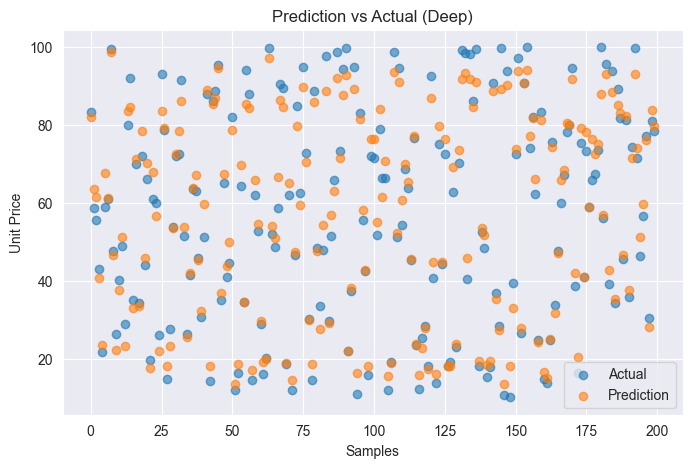

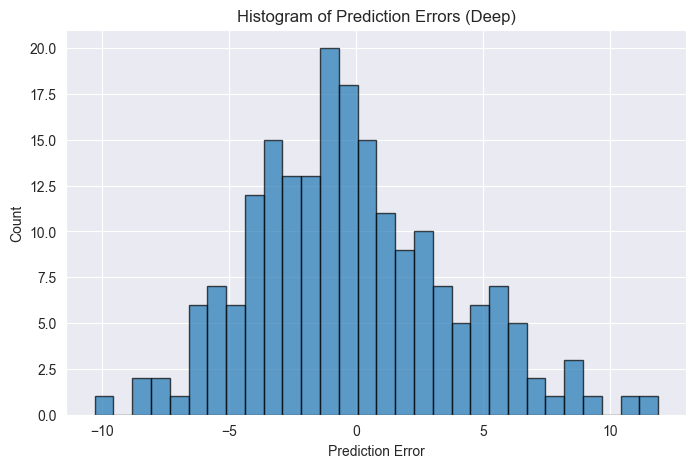

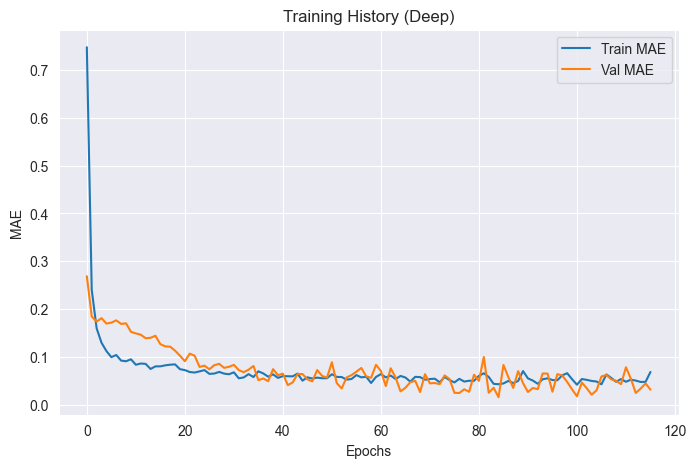

In [109]:
title = 'Deep'
mae = mean_absolute_error(Y_actual, Y_pred)
mse = mean_squared_error(Y_actual, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_actual, Y_pred)
wynikowa.loc[len(wynikowa)]=[title,mae,mse,rmse,r2]
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")
plt.figure(figsize=(8,5))
plt.scatter(range(len(Y_actual)), Y_actual, label="Actual", alpha=0.6)
plt.scatter(range(len(Y_pred)), Y_pred, label="Prediction", alpha=0.6)
plt.xlabel("Samples")
plt.ylabel("Unit Price")
plt.title("Prediction vs Actual (Deep)")
plt.legend()
plt.show()

errors = Y_actual - Y_pred
plt.figure(figsize=(8,5))
plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("Histogram of Prediction Errors (Deep)")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training History (Deep)")
plt.legend()
plt.show()

In [110]:
wynikowa

,title,MAE,MSE,RMSE,R2
0,Bayesian parameters,2.228991,6.641063,2.577026,0.991092
1,Simple,2.931961,15.705352,3.962998,0.978934
2,Medium,1.996112,6.676429,2.583879,0.991045
3,Deep,3.116124,15.617717,3.951926,0.979051


In [111]:
def build_model_tuner(hp):
    model = Sequential()
    for i in range(hp.Int("num_layers", 3, 5)):
        model.add(layers.Dense(
            units=hp.Int("units_" + str(i), 16, 128, step=16),
            activation='relu'
        ))
        model.add(layers.Dropout(hp.Float("dropout_" + str(i), 0.0, 0.5, step=0.1)))
    model.add(layers.Dense(1, activation='linear'))

    lr = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='mse', metrics=['mae'])
    return model

In [112]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model_tuner,
    objective='val_mae',
    max_trials=20,
    directory='tuner_dir',
    project_name='supermarket_price4'
)

Reloading Tuner from tuner_dir\supermarket_price4\tuner0.json


In [113]:
tuner.search(
    X_train_scaled,
    Y_train_scaled,
    validation_split=0.2,
    epochs=50,
    callbacks=[EarlyStopping(patience=5)]
)

In [114]:
best_model_nowy = tuner.get_best_models(1)[0]
best_hp_nowy = tuner.get_best_hyperparameters(1)[0]
print(best_hp_nowy.values)

{'num_layers': 4, 'units_0': 16, 'dropout_0': 0.0, 'units_1': 80, 'dropout_1': 0.0, 'units_2': 112, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.01, 'units_3': 48, 'dropout_3': 0.1, 'units_4': 32, 'dropout_4': 0.2}


C:\Users\mateuszlamla\PyCharmMiscProject\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


--- Rozpoczynam eksportowanie modelu i danych ---
1. Model zapisany jako 'best_price_model.keras'
2. Odtwarzanie mapowań kategorycznych...
   - Zakodowano Branch: 3 kategorii
   - Zakodowano City: 3 kategorii
   - Zakodowano Customer type: 2 kategorii
   - Zakodowano Gender: 2 kategorii
   - Zakodowano Product line: 6 kategorii
   - Zakodowano Payment: 3 kategorii
3. Artefakty zapisane jako 'preprocessing_artifacts.pkl'

GOTOWE! Możesz teraz używać plików .keras i .pkl w Agencie.
